# Text Classification - Detect & Clean incorrect labels using cleanlab

In [ ]:
# make your Google Drive accessible
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive"
drive_data = f"{root_dir}/Colab Notebooks/data/disaster_tweet"

Mounted at /content/gdrive


In [ ]:
# !pip install light-the-torch 
# !ltt install torch torchvision

In [ ]:
# !pip install -Uqq pandas --upgrade
# !pip install -Uqq fastcore --upgrade
# !pip install -Uqq fastai --upgrade 
# !pip install -q nbdev
# !pip install sentencepiece 

from pathlib import Path

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.text.all import *
from fastcore.test import * 
#import fastai; fastai.utils.show_install()

In [ ]:
def replace_space(text, sep='_'):
  return sep.join(text.split(' '))

In [ ]:
def modify_metadata(column_value, tag_name):
  data = f"{tag_name}_{replace_space(column_value)}"
  data.replace(',', '')
  return data

In [ ]:
modify_metadata('Jeremy Howard', 'aut_name')

'aut_name_Jeremy_Howard'

In [ ]:
def clean_text(word):

  #Remove urls
  urls = re.findall(r'https?://\S+', word)
  if len(urls) > 0:
    word = ""
    return word
  
  return word.strip()

In [ ]:
Config.DEFAULT_CONFIG = {
        'data_path': f'{drive_data}',
        'data_archive_path': f'{drive_data}',
        'model_path': f'{drive_data}' + '/models'
    }

In [ ]:
Config.DEFAULT_CONFIG

{'data_archive_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet',
 'data_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet',
 'model_path': '/content/gdrive/My Drive/Colab Notebooks/data/disaster_tweet/models'}

In [ ]:
bs=64

In [ ]:
disaster_tweet = f"{drive_data}"; disaster_tweet
disaster = Path(disaster_tweet)

In [ ]:
train_df = pd.read_csv(disaster/'train.csv');train_df.head()
test_df = pd.read_csv(disaster/'test.csv');

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([clean_text(each) for each in x.split(' ')]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([clean_text(each) for each in x.split(' ')]))

In [ ]:
import numpy as np
train_df['keyword'] = train_df['keyword'].replace(np.nan, 'NA', regex=True)
test_df['keyword'] = test_df['keyword'].replace(np.nan, 'NA', regex=True)

In [ ]:
dls_lm = TextDataLoaders.from_df(pd.concat([train_df, test_df]), seed=42, text_col='text', is_lm=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
lang_learn = language_model_learner(dls_lm, AWD_LSTM, metrics=Perplexity())

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.05754399299621582)

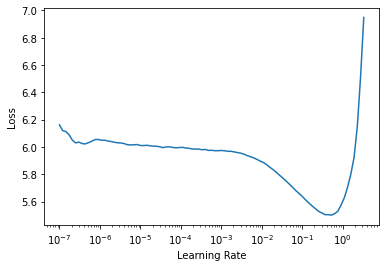

In [ ]:
lang_learn.lr_find()

In [ ]:
lang_learn.fine_tune(3, 5e-2)

epoch,train_loss,valid_loss,perplexity,time
0,4.869072,4.222111,68.177238,00:15


epoch,train_loss,valid_loss,perplexity,time
0,3.882690,3.805628,44.953487,00:17
1,3.605679,3.606257,36.827946,00:18
2,3.268116,3.602493,36.689598,00:18


In [ ]:
lang_learn.save_encoder('fine_tuned_enc')

In [ ]:
dls = TextDataLoaders.from_df(train_df, seed=42, text_col='text', label_col='target', y_block=CategoryBlock(), is_lm=False, text_vocab=dls_lm.vocab)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn = text_classifier_learner(dls, arch=AWD_LSTM, metrics=accuracy)

In [ ]:
learn.load_encoder('fine_tuned_enc')

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.007585775572806597)

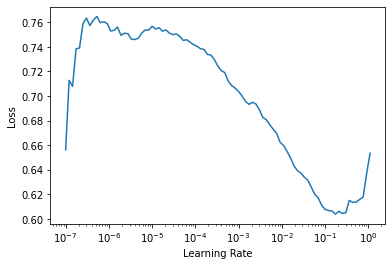

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.517189,0.488224,0.777267,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.468717,0.454412,0.796321,00:10
1,0.433061,0.447050,0.798949,00:10
2,0.360648,0.467646,0.795664,00:10


In [ ]:
!pip install cleanlab

     |████████████████████████████████| 58 kB 6.7 MB/s 


In [ ]:
learn.dls.train

In [ ]:
train_dl = learn.dls.test_dl(tokenize_df(train_df, text_cols='text')[0])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
train_preds = learn.get_preds(dl=train_dl, with_decoded=True)

In [ ]:
train_preds[0].shape

torch.Size([7613, 2])

In [ ]:
train_df.target.values

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
train_df.target.values.shape

(7613,)

In [ ]:
train_preds[0].numpy()

array([[0.4174578 , 0.58254224],
       [0.00218836, 0.9978116 ],
       [0.18324117, 0.8167588 ],
       ...,
       [0.02872721, 0.97127277],
       [0.01679658, 0.9832034 ],
       [0.01257689, 0.9874232 ]], dtype=float32)

In [ ]:
from cleanlab.pruning import get_noise_indices

In [ ]:
ordered_label_errors = get_noise_indices(s=train_df.target.values, psx=train_preds[0].numpy(), sorted_index_method='normalized_margin')

In [ ]:
len(ordered_label_errors)

383

In [ ]:
train_df.loc[ordered_label_errors][['text', 'target']][:50]

,text,target
3991,@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods,0
3806,Former Township fire truck being used in Philippines - Langley Times #filipino,0
2269,Rand Paul's Debate Strategy 'demolish Some other bad ideas out there or point out maybe that there are some em...,1
1315,My hand is burning,1
5463,.@slosheriff: 2 South Gate police officers and 2 Huntington Park officers arrested after child abuse investigation at boot camp,0
2877,Large rain drops falling in Rock Hill off Anderson Road. #rain #scwx #drought,0
2236,If you're in search of powerful content to improve your business or have been frustrated with the deluge of,1
547,STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay,1
3913,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_,1
3278,#Tanzania elephant population declined by 60% in five years census reveals,0


In [ ]:
error_df = train_df.loc[ordered_label_errors]

In [ ]:
clean_idx = [idx for idx, _ in enumerate(train_df.values) if not idx in ordered_label_errors]

In [ ]:
train_df.loc[clean_idx]

,id,keyword,location,text,target
0,1,NA,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NA,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NA,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NA,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NA,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NA,NaN,Two giant cranes holding a bridge collapse into nearby homes,1
7609,10870,NA,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NA,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1
7611,10872,NA,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [ ]:
clean_train_df = train_df.loc[clean_idx]

In [ ]:
dls = TextDataLoaders.from_df(clean_train_df, seed=42, text_col=['keyword', 'text'], label_col='target', y_block=CategoryBlock(), is_lm=False, text_vocab=dls_lm.vocab)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn = text_classifier_learner(dls, arch=AWD_LSTM, metrics=accuracy)
learn.load_encoder('fine_tuned_enc')

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=6.309573450380412e-07)

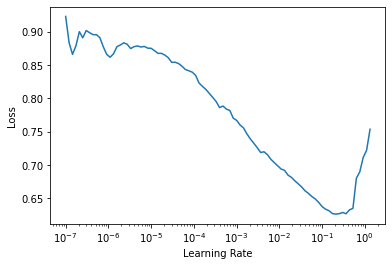

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.485073,0.425624,0.811203,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.407019,0.346976,0.856155,00:10
1,0.372527,0.343793,0.858921,00:10
2,0.323204,0.633997,0.769710,00:10
3,0.262023,0.370186,0.858921,00:10
4,0.215317,0.383070,0.843015,00:10
5,0.142278,0.513578,0.857538,00:10
6,0.095367,0.589843,0.847165,00:10
7,0.065511,0.615701,0.857538,00:10
8,0.041297,0.651564,0.854772,00:10
9,0.040339,0.665134,0.852006,00:10


In [ ]:
learn.validate()

(#2) [0.665134072303772,0.8520055413246155]